## Atividade Prática VI

Este trabalho tem como objetivo aplicar o algoritmo Random Forest na base de dados Madelon, desenvolvida para o NIPS 2003 Feature Selection Challenge. A base apresenta alta dimensionalidade e variáveis irrelevantes, tornando o problema de classificação desafiador. Foram realizados experimentos em dois cenários  "dados normalizados e não normalizados"   e comparadas três abordagens de predição: votação majoritária (hard voting), ponderada (weighted voting) e suave (soft voting).

Preparação do ambiente e importação das bibliotecas

In [30]:
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

/home/emilly/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Download da base Madelon

In [4]:

zip_path = "/home/emilly/Trabalho Topicos_florest/Madelon-RandomForest-Classification/madelon.zip"
extract_path = "/home/emilly/Trabalho Topicos_florest/Madelon-RandomForest-Classification/dataset"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Arquivos extraídos com sucesso!")
print("Conteúdo da pasta 'dataset/':")
print(os.listdir(extract_path))


Arquivos extraídos com sucesso!
Conteúdo da pasta 'dataset/':
['madelon_valid.labels', 'Dataset.pdf', 'MADELON']


Analise do dataset

In [8]:

base_path = "/home/emilly/Trabalho Topicos_florest/Madelon-RandomForest-Classification/dataset/MADELON"
train_data_path = os.path.join(base_path, "madelon_train.data")
train_labels_path = os.path.join(base_path, "madelon_train.labels")


X = pd.read_csv(train_data_path, sep=" ", header=None)
y = pd.read_csv(train_labels_path, sep=" ", header=None)

X = X.dropna(axis=1, how='all')

print("Dimensões dos dados:")
print(f"X (atributos): {X.shape}")
print(f"y (rótulos): {y.shape}\n")

print("Primeiras linhas dos atributos:")
display(X.head())

print("Distribuição das classes:")
print(y.value_counts().rename_axis("Classe").reset_index(name="Frequência"))

# Estatísticas básicas
print("\n Estatísticas dos atributos (amostra):")
display(X.describe().T.head(10))


Dimensões dos dados:
X (atributos): (2000, 500)
y (rótulos): (2000, 1)

Primeiras linhas dos atributos:


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,485,477,537,479,452,471,491,476,475,473,...,477,481,477,485,511,485,481,479,475,496
1,483,458,460,487,587,475,526,479,485,469,...,463,478,487,338,513,486,483,492,510,517
2,487,542,499,468,448,471,442,478,480,477,...,487,481,492,650,506,501,480,489,499,498
3,480,491,510,485,495,472,417,474,502,476,...,491,480,474,572,454,469,475,482,494,461
4,484,502,528,489,466,481,402,478,487,468,...,488,479,452,435,486,508,481,504,495,511


Distribuição das classes:
   Classe  Frequência
0      -1        1000
1       1        1000

 Estatísticas dos atributos (amostra):


,count,mean,std,min,25%,50%,75%,max
0,2000.0,481.7225,6.421769,462.0,477.00,482.0,486.00,503.0
1,2000.0,483.4525,30.186294,381.0,464.00,483.0,503.00,600.0
2,2000.0,510.1660,38.899165,370.0,485.00,510.5,536.00,654.0
3,2000.0,483.3845,9.059895,453.0,477.00,483.0,490.00,519.0
4,2000.0,501.6125,41.389418,371.0,475.00,500.0,528.00,688.0
5,2000.0,479.2590,6.795956,459.0,475.00,479.0,484.00,505.0
6,2000.0,480.1095,40.575925,334.0,452.75,480.0,506.25,611.0
7,2000.0,476.5650,1.384461,471.0,476.00,477.0,477.00,481.0
8,2000.0,486.7935,15.043836,430.0,477.00,487.0,496.25,536.0
9,2000.0,478.7890,7.190920,455.0,474.00,479.0,484.00,503.0


##  Cenários de Classificação: 

Dados não normalizados 

In [ ]:

base_path = "/home/emilly/Trabalho Topicos_florest/Madelon-RandomForest-Classification/dataset/MADELON"
train_data_path = os.path.join(base_path, "madelon_train.data")
train_labels_path = os.path.join(base_path, "madelon_train.labels")

X = pd.read_csv(train_data_path, sep=" ", header=None)
y = pd.read_csv(train_labels_path, sep=" ", header=None)

X = X.dropna(axis=1, how='all')
y = y.squeeze()

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Treinamento com Random Forest
modelo = RandomForestClassifier(
    n_estimators=200, random_state=42, n_jobs=-1
)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)


print("============================================")
print(" CENÁRIO 1: SEM NORMALIZAÇÃO")
print("============================================")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


 CENÁRIO 1: SEM NORMALIZAÇÃO
Acurácia: 0.6600

Relatório de Classificação:
              precision    recall  f1-score   support

          -1       0.65      0.68      0.67       300
           1       0.67      0.64      0.65       300

    accuracy                           0.66       600
   macro avg       0.66      0.66      0.66       600
weighted avg       0.66      0.66      0.66       600


Matriz de Confusão:
[[203  97]
 [107 193]]


Dados normalizados

In [16]:

base_path = "/home/emilly/Trabalho Topicos_florest/Madelon-RandomForest-Classification/dataset/MADELON"
train_data_path = os.path.join(base_path, "madelon_train.data")
train_labels_path = os.path.join(base_path, "madelon_train.labels")


X = pd.read_csv(train_data_path, sep=" ", header=None)
y = pd.read_csv(train_labels_path, sep=" ", header=None)

X = X.dropna(axis=1, how='all')
y = y.squeeze()

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinamento com Random Forest
modelo = RandomForestClassifier(
    n_estimators=200, random_state=42, n_jobs=-1
)
modelo.fit(X_train_scaled, y_train)
y_pred = modelo.predict(X_test_scaled)

print("============================================")
print("CENÁRIO 2: COM NORMALIZAÇÃO")
print("============================================")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


CENÁRIO 2: COM NORMALIZAÇÃO
Acurácia: 0.6650

Relatório de Classificação:
              precision    recall  f1-score   support

          -1       0.66      0.68      0.67       300
           1       0.67      0.65      0.66       300

    accuracy                           0.67       600
   macro avg       0.67      0.67      0.66       600
weighted avg       0.67      0.67      0.66       600


Matriz de Confusão:
[[205  95]
 [106 194]]


# Sistemática experimental 

Dados não normalizados

In [ ]:

base_path = "/home/emilly/Trabalho Topicos_florest/Madelon-RandomForest-Classification/dataset/MADELON"
train_data_path = os.path.join(base_path, "madelon_train.data")
train_labels_path = os.path.join(base_path, "madelon_train.labels")

X = pd.read_csv(train_data_path, sep=" ", header=None)
y = pd.read_csv(train_labels_path, sep=" ", header=None)

X = X.dropna(axis=1, how='all')
y = y.squeeze()

# Divisão hold-out (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Modelo Random Forest
modelo = RandomForestClassifier(
    n_estimators=200, random_state=42, n_jobs=-1
)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)


print("============================================")
print("CENÁRIO 1: SEM NORMALIZAÇÃO (HOLD-OUT 80/20)")
print("============================================")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


CENÁRIO 1: SEM NORMALIZAÇÃO (HOLD-OUT 80/20)
Acurácia: 0.6875

Relatório de Classificação:
              precision    recall  f1-score   support

          -1       0.68      0.72      0.70       200
           1       0.70      0.66      0.68       200

    accuracy                           0.69       400
   macro avg       0.69      0.69      0.69       400
weighted avg       0.69      0.69      0.69       400


Matriz de Confusão:
[[144  56]
 [ 69 131]]


Dados normalizados

In [ ]:

base_path = "/home/emilly/Trabalho Topicos_florest/Madelon-RandomForest-Classification/dataset/MADELON"
train_data_path = os.path.join(base_path, "madelon_train.data")
train_labels_path = os.path.join(base_path, "madelon_train.labels")

X = pd.read_csv(train_data_path, sep=" ", header=None)
y = pd.read_csv(train_labels_path, sep=" ", header=None)

X = X.dropna(axis=1, how='all')
y = y.squeeze()

# Divisão hold-out (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo Random Forest
modelo = RandomForestClassifier(
    n_estimators=200, random_state=42, n_jobs=-1
)
modelo.fit(X_train_scaled, y_train)
y_pred = modelo.predict(X_test_scaled)


print("============================================")
print("CENÁRIO 2: COM NORMALIZAÇÃO (HOLD-OUT 80/20)")
print("============================================")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


⚙️ CENÁRIO 2: COM NORMALIZAÇÃO (HOLD-OUT 80/20)
Acurácia: 0.6800

Relatório de Classificação:
              precision    recall  f1-score   support

          -1       0.67      0.72      0.69       200
           1       0.70      0.64      0.67       200

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.68      0.68      0.68       400


Matriz de Confusão:
[[144  56]
 [ 72 128]]


# Aplicação do Algoritmo 

Aplicação do algoritmo Random Forest na classificação dos dados utilizando os 
seguintes métodos para determinar a predição:
* votação majoritária
* votação ponderada
* votação suave (soft voting).


CENÁRIO NORMALIZADO

In [ ]:

base_path = "/home/emilly/Trabalho Topicos_florest/Madelon-RandomForest-Classification/dataset/MADELON"
train_data_path = os.path.join(base_path, "madelon_train.data")
train_labels_path = os.path.join(base_path, "madelon_train.labels")

X = pd.read_csv(train_data_path, sep=" ", header=None).dropna(axis=1, how="all")
y = pd.read_csv(train_labels_path, sep=" ", header=None).squeeze()

# Divisão hold-out 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelos base
rf = RandomForestClassifier(n_estimators=200, random_state=42)
lr = LogisticRegression(max_iter=2000, random_state=42)
svm = SVC(probability=True, random_state=42)

# Treinar cada modelo individualmente (para calcular pesos)
rf.fit(X_train_scaled, y_train)
lr.fit(X_train_scaled, y_train)
svm.fit(X_train_scaled, y_train)

# Calcular acurácia individual (para pesos)
acc_rf = accuracy_score(y_test, rf.predict(X_test_scaled))
acc_lr = accuracy_score(y_test, lr.predict(X_test_scaled))
acc_svm = accuracy_score(y_test, svm.predict(X_test_scaled))
pesos = [acc_rf, acc_lr, acc_svm]

print(f"Acurácias Individuais: RF={acc_rf:.3f}, LR={acc_lr:.3f}, SVM={acc_svm:.3f}\n")

# Votação Majoritária
vot_majoritaria = VotingClassifier(
    estimators=[('rf', rf), ('lr', lr), ('svm', svm)],
    voting='hard'
)
vot_majoritaria.fit(X_train_scaled, y_train)
pred_majoritaria = vot_majoritaria.predict(X_test_scaled)
acc_majoritaria = accuracy_score(y_test, pred_majoritaria)

# Votação Ponderada
vot_ponderada = VotingClassifier(
    estimators=[('rf', rf), ('lr', lr), ('svm', svm)],
    voting='hard',
    weights=pesos
)
vot_ponderada.fit(X_train_scaled, y_train)
pred_ponderada = vot_ponderada.predict(X_test_scaled)
acc_ponderada = accuracy_score(y_test, pred_ponderada)

# Votação Suave (Soft Voting)
vot_suave = VotingClassifier(
    estimators=[('rf', rf), ('lr', lr), ('svm', svm)],
    voting='soft',
    weights=pesos
)
vot_suave.fit(X_train_scaled, y_train)
pred_suave = vot_suave.predict(X_test_scaled)
acc_suave = accuracy_score(y_test, pred_suave)



print("============================================")
print("RESULTADOS - CENÁRIO NORMALIZADO (80/20)")
print("============================================")
print(f"Votação Majoritária: {acc_majoritaria:.4f}")
print(f"Votação Ponderada:   {acc_ponderada:.4f}")
print(f"Votação Suave:       {acc_suave:.4f}")


Acurácias Individuais: RF=0.680, LR=0.540, SVM=0.550

RESULTADOS - CENÁRIO NORMALIZADO (80/20)
Votação Majoritária: 0.5775
Votação Ponderada:   0.5775
Votação Suave:       0.5725


# Resultados e Discussão

In [33]:


# Tabela 1: Desempenho do Random Forest em diferentes cenários
data_rf_scenarios = {
    'Cenário': [
        'Sem Normalização (70/30)',
        'Com Normalização (70/30)',
        'Sem Normalização (80/20)',
        'Com Normalização (80/20)'
    ],
    'Acurácia': [0.6600, 0.6650, 0.6875, 0.6800]
}
df_rf_scenarios = pd.DataFrame(data_rf_scenarios)

# Tabela 2: Comparação entre Modelos Individuais e Comitês (Ensembles)
data_comparison = {
    'Tipo de Modelo': ['Individual', 'Individual', 'Individual', 'Comitê', 'Comitê', 'Comitê'],
    'Modelo': [
        'Random Forest',
        'Regressão Logística',
        'SVM',
        'Votação Majoritária',
        'Votação Ponderada',
        'Votação Suave'
    ],
    'Acurácia': [0.6800, 0.5400, 0.5500, 0.5775, 0.5775, 0.5725]
}
df_comparison = pd.DataFrame(data_comparison)

print("--- Tabela 1: Acurácia do Random Forest por Cenário ---")
print(df_rf_scenarios.to_string(index=False))
print("\n" + "="*60 + "\n")
print("--- Tabela 2: Comparação de Acurácia - Modelos Individuais vs. Comitês ---")

print(df_comparison.sort_values('Acurácia', ascending=False).to_string(index=False))
print("\n" + "="*60 + "\n")


--- Tabela 1: Acurácia do Random Forest por Cenário ---
                 Cenário  Acurácia
Sem Normalização (70/30)    0.6600
Com Normalização (70/30)    0.6650
Sem Normalização (80/20)    0.6875
Com Normalização (80/20)    0.6800


--- Tabela 2: Comparação de Acurácia - Modelos Individuais vs. Comitês ---
Tipo de Modelo              Modelo  Acurácia
    Individual       Random Forest    0.6800
        Comitê Votação Majoritária    0.5775
        Comitê   Votação Ponderada    0.5775
        Comitê       Votação Suave    0.5725
    Individual                 SVM    0.5500
    Individual Regressão Logística    0.5400




Graficos 

Gráfico 1 (Impacto da Normalização) salvo com sucesso.


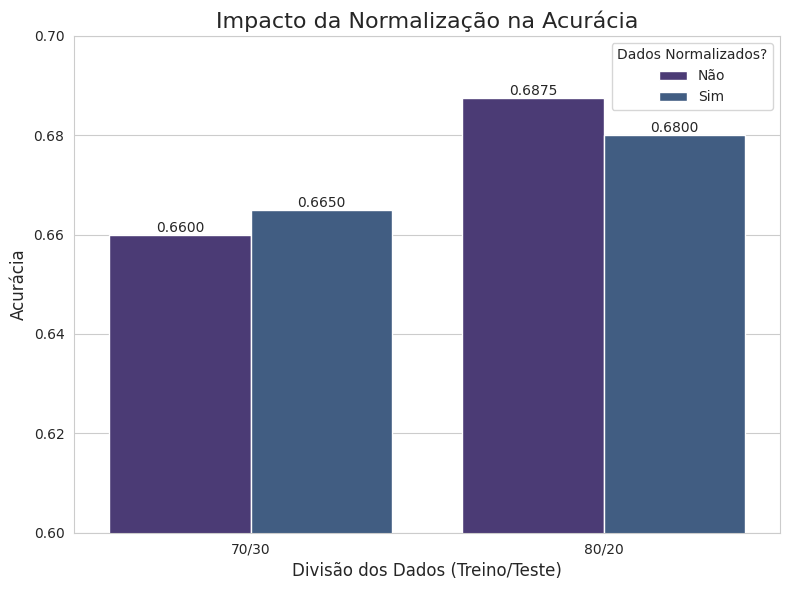

Gráfico 2 (Impacto da Divisão dos Dados) salvo com sucesso.


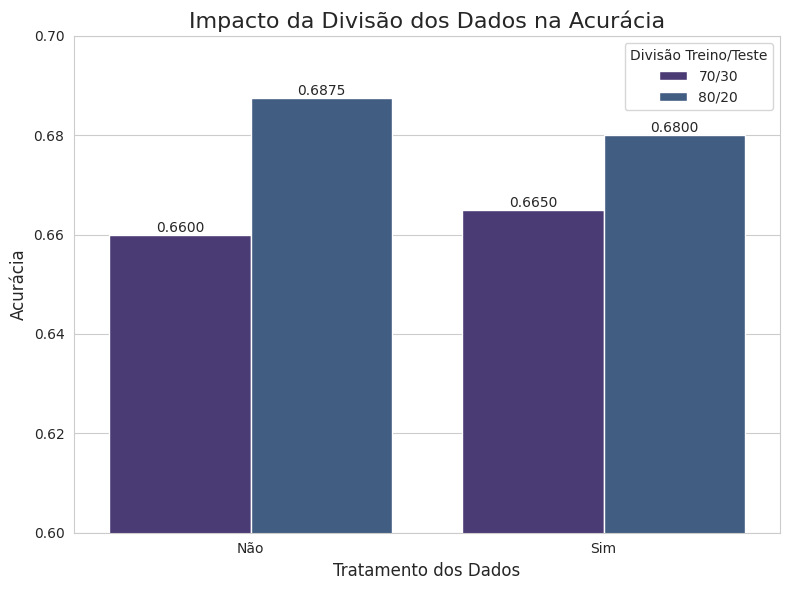

Gráfico 3 (Modelos Individuais) salvo com sucesso.


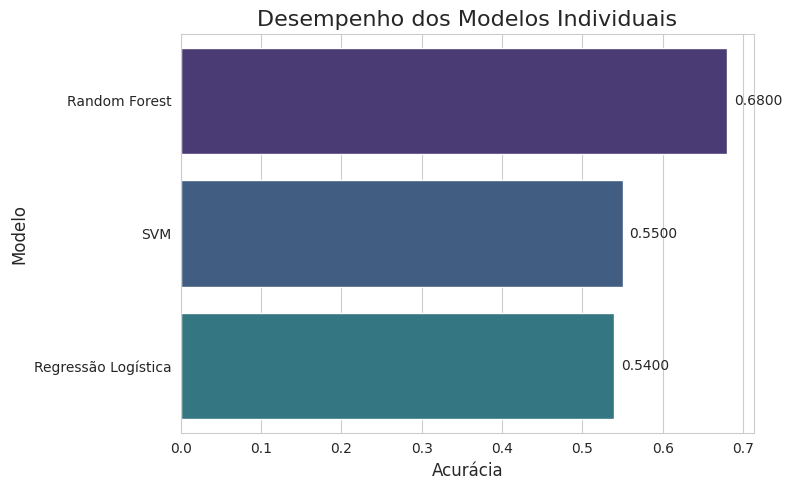

Gráfico 4 (Métodos de Ensemble) salvo com sucesso.


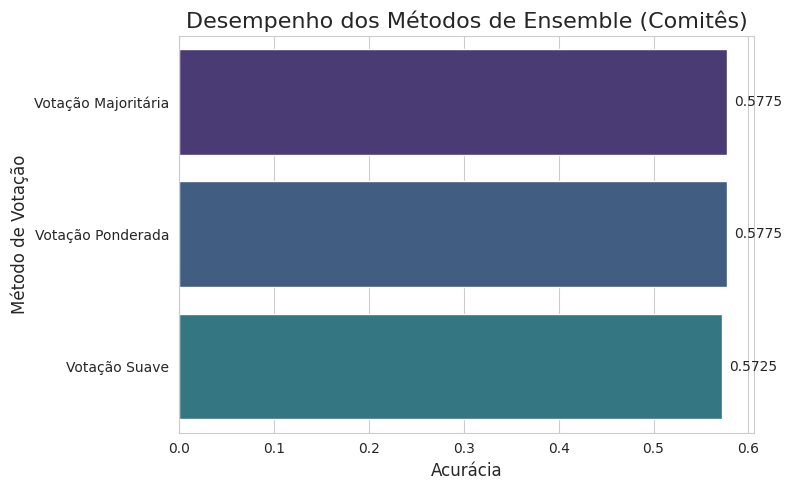

In [ ]:

df_cenarios = pd.DataFrame({
    'Divisão': ['70/30', '70/30', '80/20', '80/20'],
    'Normalização': ['Não', 'Sim', 'Não', 'Sim'],
    'Acurácia': [0.6600, 0.6650, 0.6875, 0.6800]
})

df_comparacao = pd.DataFrame({
    'Tipo de Modelo': ['Individual', 'Individual', 'Individual', 'Comitê', 'Comitê', 'Comitê'],
    'Modelo': [
        'Random Forest', 'Regressão Logística', 'SVM',
        'Votação Majoritária', 'Votação Ponderada', 'Votação Suave'
    ],
    'Acurácia': [0.6800, 0.5400, 0.5500, 0.5775, 0.5775, 0.5725]
})

# Configurações de Estilo 
sns.set_style("whitegrid")
sns.set_palette("viridis")

# Gráfico 1: Foco no Impacto da Normalização 
plt.figure(figsize=(8, 6))
ax1 = sns.barplot(data=df_cenarios, x='Divisão', y='Acurácia', hue='Normalização')
plt.title('Impacto da Normalização na Acurácia', fontsize=16)
plt.ylabel('Acurácia', fontsize=12)
plt.xlabel('Divisão dos Dados (Treino/Teste)', fontsize=12)
plt.ylim(0.60, 0.70)
plt.legend(title='Dados Normalizados?')


for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.4f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 5),
                 textcoords='offset points')

plt.tight_layout()
plt.savefig('grafico_1_impacto_normalizacao.png', dpi=300)
print("Gráfico 1 (Impacto da Normalização) salvo com sucesso.")
plt.show()


# Gráfico 2: Foco no Impacto da Divisão dos Dados (Split) 
plt.figure(figsize=(8, 6))
ax2 = sns.barplot(data=df_cenarios, x='Normalização', y='Acurácia', hue='Divisão')
plt.title('Impacto da Divisão dos Dados na Acurácia', fontsize=16)
plt.ylabel('Acurácia', fontsize=12)
plt.xlabel('Tratamento dos Dados', fontsize=12)
plt.ylim(0.60, 0.70)
plt.legend(title='Divisão Treino/Teste')

for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.4f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 5),
                 textcoords='offset points')

plt.tight_layout()
plt.savefig('grafico_2_impacto_split.png', dpi=300)
print("Gráfico 2 (Impacto da Divisão dos Dados) salvo com sucesso.")
plt.show()


# Gráfico 3: Desempenho dos Modelos Individuais -
df_individuais = df_comparacao[df_comparacao['Tipo de Modelo'] == 'Individual'].sort_values('Acurácia', ascending=False)
plt.figure(figsize=(8, 5))
ax3 = sns.barplot(data=df_individuais, x='Acurácia', y='Modelo')
plt.title('Desempenho dos Modelos Individuais', fontsize=16)
plt.xlabel('Acurácia', fontsize=12)
plt.ylabel('Modelo', fontsize=12)

for p in ax3.patches:
    width = p.get_width()
    ax3.annotate(f'{width:.4f}',
                 xy=(width, p.get_y() + p.get_height() / 2),
                 xytext=(5, 0), textcoords='offset points',
                 ha='left', va='center')

plt.tight_layout()
plt.savefig('grafico_3_desempenho_individuais.png', dpi=300)
print("Gráfico 3 (Modelos Individuais) salvo com sucesso.")
plt.show()


# Gráfico 4: Desempenho dos Métodos de Ensemble (Comitês)
df_ensembles = df_comparacao[df_comparacao['Tipo de Modelo'] == 'Comitê'].sort_values('Acurácia', ascending=False)
plt.figure(figsize=(8, 5))
ax4 = sns.barplot(data=df_ensembles, x='Acurácia', y='Modelo')
plt.title('Desempenho dos Métodos de Ensemble (Comitês)', fontsize=16)
plt.xlabel('Acurácia', fontsize=12)
plt.ylabel('Método de Votação', fontsize=12)

for p in ax4.patches:
    width = p.get_width()
    ax4.annotate(f'{width:.4f}',
                 xy=(width, p.get_y() + p.get_height() / 2),
                 xytext=(5, 0), textcoords='offset points',
                 ha='left', va='center')

plt.tight_layout()
plt.savefig('grafico_4_desempenho_ensembles.png', dpi=300)
print("Gráfico 4 (Métodos de Ensemble) salvo com sucesso.")
plt.show()